In [121]:
import requests
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
from pytrends import dailydata
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [194]:
# Define company variables
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft', 'apple', 'snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT', 'AAPL', 'SNAP']
stock_columns = ['open', 'high', 'low', 'close', 'volume']

In [195]:
# Create Key Words List for Pytrends
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

In [196]:
# Get Hourly trends data from pytrends
# If there is a server 500 error, try changing the dates to this past week! 
df = pd.DataFrame()
data = {}
pytrends = TrendReq(hl='en-US', tz=360)
for kw in kw_list:
    print(kw)
    df_temp = pytrends.get_historical_interest([kw], year_start=2019, month_start=11, day_start=25, hour_start=0, year_end=2019, month_end=11, day_end=29, hour_end=23)
    if 'isPartial' in df_temp.columns: 
        df_temp = df_temp.drop(['isPartial'], axis=1)
    data[kw] = df_temp
for kw in kw_list:
    if df.empty:
        df = data[kw]
    else:
        df = df.join(data[kw])

tesla report
tesla good
tesla bad
tesla up
tesla down
tesla stock
facebook report
facebook good
facebook bad
facebook up
facebook down
facebook stock
microsoft report
microsoft good
microsoft bad
microsoft up
microsoft down
microsoft stock
amazon report
amazon good
amazon bad
amazon up
amazon down
amazon stock
google report
google good
google bad
google up
google down
google stock
uber report
uber good
uber bad
uber up
uber down
uber stock
lyft report
lyft good
lyft bad
lyft up
lyft down
lyft stock
apple report
apple good
apple bad
apple up
apple down
apple stock
snap report
snap good
snap bad
snap up
snap down
snap stock


In [197]:
#Sanity check on the data 
print(df.head())
print(df.shape)
print(df.index)
print(df.columns)

                     tesla report  tesla good  tesla bad  tesla up  \
date                                                                 
2019-11-25 00:00:00            47          80        100        91   
2019-11-25 01:00:00            77          77         76        87   
2019-11-25 02:00:00            66         100         93        81   
2019-11-25 03:00:00            72          70         65        70   
2019-11-25 04:00:00            65          65         80        67   

                     tesla down  tesla stock  facebook report  facebook good  \
date                                                                           
2019-11-25 00:00:00          96           47               81             82   
2019-11-25 01:00:00          76           50               74             80   
2019-11-25 02:00:00         100           49               79            100   
2019-11-25 03:00:00          92           52               83             91   
2019-11-25 04:00:00          

In [198]:
# worldTradingData_APIKey = ''
# def getWorldTradingData_Intraday1min(symbol, days=1, interval=1) :
#     # limits on the inputs https://www.worldtradingdata.com/documentation#stock-and-index-intraday
#     link = "https://intraday.worldtradingdata.com/api/v1/intraday?symbol={}&range={}&interval={}&api_token={}"\
#         .format(symbol, days, interval, worldTradingData_APIKey)
#     request = requests.get(link)
#     data = json.loads(request.text)
#     if 'intraday' not in data:
#         return pd.DataFrame()
#     stock_data = json.dumps(data["intraday"])
#     df = pd.read_json(stock_data).transpose()
#     cols = ['open', 'high', 'low', 'close', 'volume']
#     df = df[cols]
#     df.reset_index(level=0, inplace=True)
#     df.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
#     return df

In [199]:
# # getting data from World Trading Data
# df_stocks = {}
# for s in company_symbol:
#     print(s)
#     res = getWorldTradingData_Intraday1min(s)
#     while res.empty:
#         time.sleep(10)
#         res = getWorldTradingData_Intraday1min(s)
#     df_stocks[s] = getWorldTradingData_Intraday1min(s)

In [200]:
# Gather Stock Data for each company and return dataframe 
ts = 'TIME_SERIES_INTRADAY'#'TIME_SERIES_DAILY'
interval = '30min'
api_key = 'E19YNB8R4JKN32DV' 
outputsize = 'full' # compact= 100 results, full= all data (5 days?)
def getIntraday1minDF(symbol): 
    link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
        .format(ts, symbol, interval, api_key, outputsize)
    request = requests.get(link)
    data = json.loads(request.text)
    if "Time Series (30min)" not in data:
        print("data limit reached")
        return pd.DataFrame()
    stock_data = json.dumps(data["Time Series (30min)"])
    df = pd.read_json(stock_data).transpose()
    cols = ['1. open', '2. high', '3. low', '4. close', '5. volume']
    df = df[cols]
    df.reset_index(level=0, inplace=True)
    df.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
    return df

In [201]:
# Gather stock data for each individual company
df_stocks = {}
for s in company_symbol:
    print(s)
    res = getIntraday1minDF(s)
    # data limit reached
    while res.empty:
        time.sleep(10)
        res = getIntraday1minDF(s)
    # add stock information to dictionary
    df_stocks[s] = res

TSLA
FB
MSFT
AMZN
GOOGL
UBER
data limit reached
data limit reached
data limit reached
LYFT
AAPL
SNAP


In [236]:
df_stocks['TSLA'].head()

,times,open,high,low,close,volume
0,2019-12-03 16:00:00,336.3300,337.11,335.940,336.0800,661249.0
1,2019-12-03 15:30:00,336.9141,337.00,336.300,336.3441,341605.0
2,2019-12-03 15:00:00,336.0800,337.76,335.990,336.8400,487437.0
3,2019-12-03 14:30:00,336.4709,336.52,335.870,336.1609,243133.0
4,2019-12-03 14:00:00,335.4400,336.85,335.378,336.4000,425940.0


In [237]:
# join Google Trends Data with Stock Market Data
df_trends_stocks = {}
def cleanAndJoinData():
    for s,c in zip(company_symbol, companies):
        print(c)
        company_names = [x for x in list(df.columns.values) if c in x]
        df_temp_trends = df[company_names]
        
        # line up indexes 
        stock_times = list(df_stocks[s].times)
        trends_times = list(df_temp_trends.index)
        joint_times = list(set(stock_times) & set(trends_times)) 
        
        print(joint_times)
        df_temp_stocks = df_stocks[s].loc[df_stocks[s]['times'].isin(joint_times)]
        df_temp_stocks = df_temp_stocks.reset_index()
        df_temp_stocks = df_temp_stocks.iloc[::-1]
        df_temp_trends = df_temp_trends.loc[df_temp_trends.index.isin(joint_times)]
        df_temp_trends = df_temp_trends.reset_index()
        df_temp_trends.columns = ['_'.join(x.split()) for x in list(df_temp_trends.columns) if len(x) > 1]
        df_trends_stocks[c] = df_temp_stocks.join(df_temp_trends)
cleanAndJoinData()

tesla
[Timestamp('2019-11-25 11:00:00'), Timestamp('2019-11-25 14:00:00'), Timestamp('2019-11-27 13:00:00'), Timestamp('2019-11-27 14:00:00'), Timestamp('2019-11-26 14:00:00'), Timestamp('2019-11-29 13:00:00'), Timestamp('2019-11-25 12:00:00'), Timestamp('2019-11-25 16:00:00'), Timestamp('2019-11-27 10:00:00'), Timestamp('2019-11-29 11:00:00'), Timestamp('2019-11-25 13:00:00'), Timestamp('2019-11-27 15:00:00'), Timestamp('2019-11-26 16:00:00'), Timestamp('2019-11-27 16:00:00'), Timestamp('2019-11-25 15:00:00'), Timestamp('2019-11-26 10:00:00'), Timestamp('2019-11-27 11:00:00'), Timestamp('2019-11-26 11:00:00'), Timestamp('2019-11-29 10:00:00'), Timestamp('2019-11-26 12:00:00'), Timestamp('2019-11-26 13:00:00'), Timestamp('2019-11-29 12:00:00'), Timestamp('2019-11-26 15:00:00'), Timestamp('2019-11-25 10:00:00'), Timestamp('2019-11-27 12:00:00')]
facebook
[Timestamp('2019-11-25 11:00:00'), Timestamp('2019-11-25 14:00:00'), Timestamp('2019-11-27 13:00:00'), Timestamp('2019-11-27 14:00:00'

In [238]:
#sanity check that data is merged correctly 
df_trends_stocks['tesla'].head()

,index,times,open,high,low,close,volume,date,tesla_report,tesla_good,tesla_bad,tesla_up,tesla_down,tesla_stock
24,71,2019-11-25 10:00:00,344.32,344.590,338.570,341.92,3775004.0,2019-11-29 13:00:00,27,11,12,23,24,18
23,69,2019-11-25 11:00:00,340.42,341.200,336.930,336.93,943990.0,2019-11-29 12:00:00,38,18,19,29,12,13
22,67,2019-11-25 12:00:00,337.50,337.570,336.015,337.22,707354.0,2019-11-29 11:00:00,28,16,19,24,14,11
21,65,2019-11-25 13:00:00,338.21,338.312,336.810,336.93,564515.0,2019-11-29 10:00:00,24,12,23,17,8,11
20,63,2019-11-25 14:00:00,337.25,337.740,336.850,337.74,402795.0,2019-11-27 16:00:00,38,30,52,42,32,50


In [239]:
# Split Training and Testing Partitions
train_size = int(len(df_trends_stocks[list(df_trends_stocks.keys())[0]])*0.8)

In [250]:
# scale data to be between 0-1 
def predictCompany(company_name, train_size, cols):
    df_temp = df_trends_stocks[company_name]
    # average price at opening and closing 
    df_temp['mid'] = (df_temp['high'] - df_temp['low']) / 2
    # scale data to be between 0-1 including average
    sc = MinMaxScaler(feature_range = (0, 1))
    data_set_scaled = sc.fit_transform(df_temp[cols+['mid']])
    
    #split training data 
    train = data_set_scaled[:train_size, :]
    test = data_set_scaled[train_size:, :]
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    #create model
    model = Sequential()
    model.add(LSTM(train_size, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    #train model
    history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    return history, model, train_X, train_y, test_X, test_y

In [241]:
# Plot MSE train/test
def plotHistory(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [242]:
# Plot test and training set predictions over true data
def plotPrediction(company, train_size, model, train_X, train_y, test_X, test_y):
    plt.plot(range(len(train_y)+len(test_y)) , list(np.array(train_y))+list(np.array(test_y)), range(len(train_y)), model.predict(train_X), '-', range(len(train_y), len(train_y)+len(test_y)), model.predict(test_X), '-')
    plt.xlabel('Day')
    plt.ylabel('Profit from previous day')
    plt.title(company + ' - predicting stock market with Keras')
    plt.legend(["True Data","Training Data", "Testing Data"])
    plt.show()

In [243]:
# Plot Predictions for Each Company
def plotCompanies(companies, train_size, cols): 
    for company in companies: 
        # Fit model and predict for each company
        history, model, train_X, train_y, test_X, test_y = predictCompany(company, train_size, cols)
        # Plot Prediction Against True Profit for Each Company
        plotPrediction(company, train_size, model, train_X, train_y, test_X, test_y)
        # Plot Error for Each Company
        plotHistory(history)     

tesla


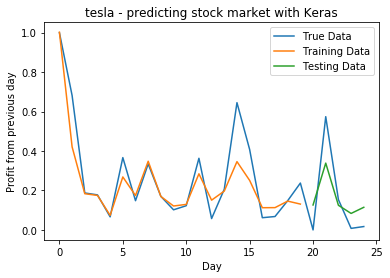

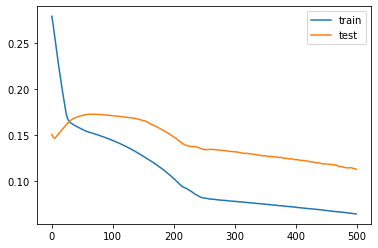

facebook


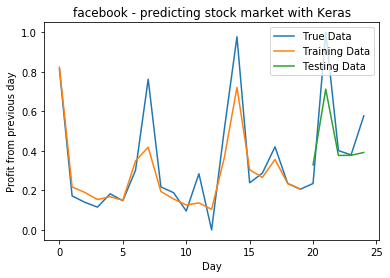

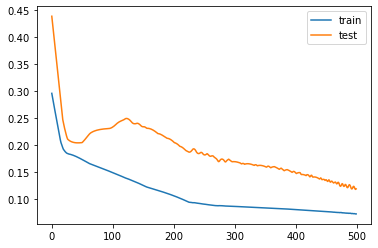

microsoft


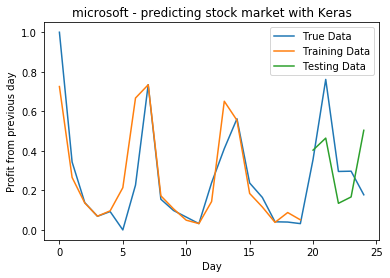

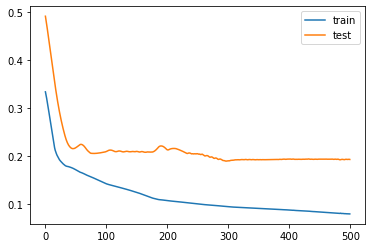

amazon


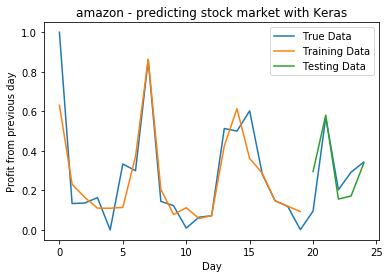

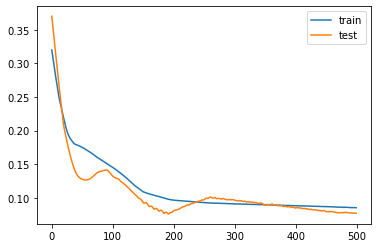

google


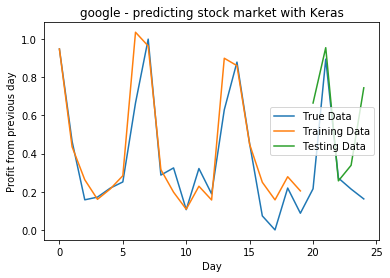

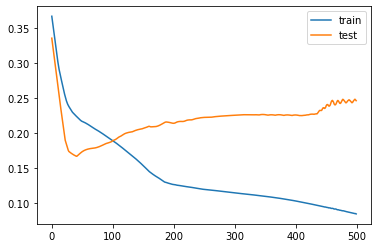

uber


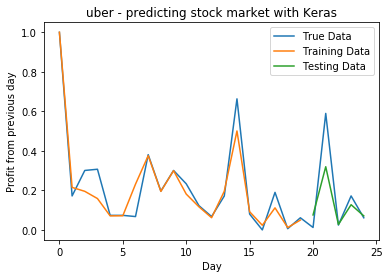

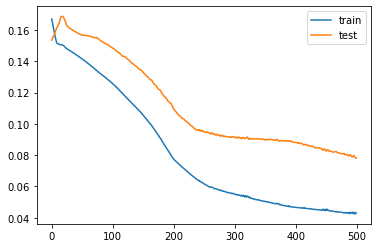

lyft


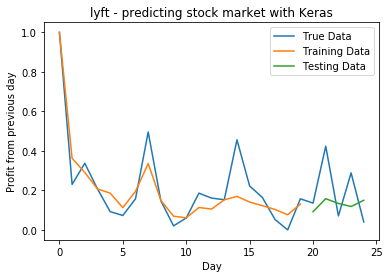

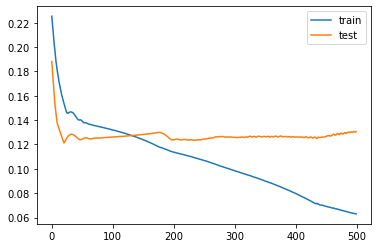

apple


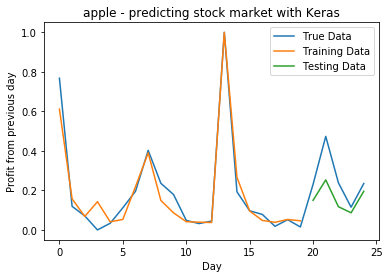

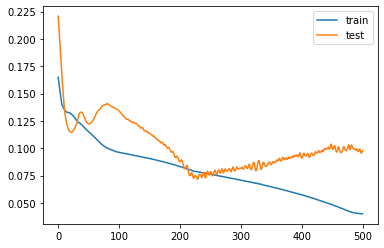

snap


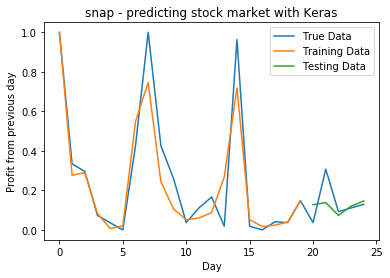

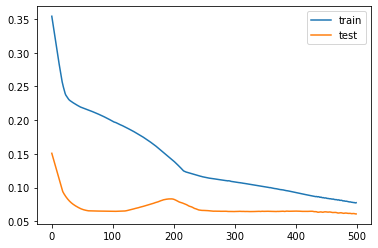

In [244]:
plotCompanies(companies, train_size, stock_columns)

In [245]:
# calculate mean squared error for each company 
MSE_train_stock_only = []
MSE_test_stock_only = []
def calculateMSE(companies, train_size, MSE_train, MSE_test, cols): 
    for company in companies: 
        history, model, train_X, train_y, test_X, test_y = predictCompany(company, train_size, cols)
        MSE_train_stock_only.append((company, mean_squared_error(model.predict(train_X), train_y)))
        MSE_test_stock_only.append((company, mean_squared_error(model.predict(test_X), test_y)))
calculateMSE(companies, train_size, MSE_train_stock_only, MSE_test_stock_only, stock_columns)

tesla
facebook
microsoft
amazon
google
uber
lyft
apple
snap


In [246]:
print(MSE_train_stock_only)
print(MSE_test_stock_only)

[('tesla', 0.01635996313460647), ('facebook', 0.01644470206186146), ('microsoft', 0.01883802688858962), ('amazon', 0.015171930099918834), ('google', 0.009903860563330102), ('uber', 0.004173302600167972), ('lyft', 0.004587200286609242), ('apple', 0.004565099529828082), ('snap', 0.014395033199827934)]
[('tesla', 0.026120309987200684), ('facebook', 0.047838993058595666), ('microsoft', 0.04466099442243152), ('amazon', 0.01098499141604288), ('google', 0.07222683336225313), ('uber', 0.013668771254134265), ('lyft', 0.017527929190303278), ('apple', 0.009942537267765457), ('snap', 0.008723010175608756)]


In [252]:
# calculate mean squared error for each company 
MSE_train_trends_only = []
MSE_test_trends_only = []
for company in companies: 
    print(company)
    cols = [x.replace(" ", "_") for x in kw_list if company in x]
    history, model, train_X, train_y, test_X, test_y = predictCompany(company, train_size, cols)
    MSE_train_trends_only.append((company, mean_squared_error(model.predict(train_X), train_y)))
    MSE_test_trends_only.append((company, mean_squared_error(model.predict(test_X), test_y)))

tesla
facebook
microsoft
amazon
google
uber
lyft
apple
snap


In [253]:
print(MSE_train_trends_only)
print(MSE_test_trends_only)

[('tesla', 0.05848500867171176), ('facebook', 0.039276793535764284), ('microsoft', 0.05803854904980216), ('amazon', 0.04207372883201598), ('google', 0.08356402592033653), ('uber', 0.04793907809245371), ('lyft', 0.043961643428032826), ('apple', 0.06535246770520842), ('snap', 0.09506317688821034)]
[('tesla', 0.05522225749866264), ('facebook', 0.14058346427159166), ('microsoft', 0.09205841522699403), ('amazon', 0.054356484147621675), ('google', 0.061982649862487915), ('uber', 0.12639759855034688), ('lyft', 0.020285025576418425), ('apple', 0.03534779925559135), ('snap', 0.029938585563052962)]


In [255]:
# calculate mean squared error for each company 
MSE_train_both = []
MSE_test_both = []
for company in companies: 
    print(company)
    cols = [x.replace(" ", "_") for x in kw_list if company in x] + stock_columns
    history, model, train_X, train_y, test_X, test_y = predictCompany(company, train_size, cols)
    MSE_train_both.append((company, mean_squared_error(model.predict(train_X), train_y)))
    MSE_test_both.append((company, mean_squared_error(model.predict(test_X), test_y)))

tesla
facebook
microsoft
amazon
google
uber
lyft
apple
snap


In [256]:
print(MSE_train_both)
print(MSE_test_both)

[('tesla', 0.006312913772121865), ('facebook', 0.006610756387042703), ('microsoft', 0.003325133523014068), ('amazon', 0.008218871404990436), ('google', 0.007729015589206625), ('uber', 0.005337818428075413), ('lyft', 0.006331761705561935), ('apple', 0.004567175623000912), ('snap', 0.009265672750322456)]
[('tesla', 0.03376342892523973), ('facebook', 0.04209166837204186), ('microsoft', 0.05431610638482237), ('amazon', 0.011246757255773987), ('google', 0.06976438696260531), ('uber', 0.020199329277101514), ('lyft', 0.029173040697204437), ('apple', 0.014831950281943295), ('snap', 0.007912454083747612)]
